In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import PIL
import time
from tqdm import tqdm, tnrange, tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import torchvision
from torchvision import transforms, datasets, models

from mpl_toolkits.axes_grid1 import ImageGrid

from senet import SENet18

In [2]:
PATH='/data/cifar10_kaggle/'
suffix='.png'

In [3]:
os.listdir(PATH)

['test',
 'test.7z',
 'trainLabels.csv',
 'sampleSubmission.csv',
 'sub',
 'weights',
 'train.7z',
 'train']

In [4]:
labels = pd.read_csv(f'{PATH}trainLabels.csv')
classes = sorted(list(set(labels['label'].tolist()))); classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
# Pre-calculated
mean, std = np.array([0.49139977, 0.4821584 , 0.4465309]), np.array([0.24703224, 0.24348513, 0.26158784])

# Explore Data

In [6]:
len(os.listdir(f'{PATH}train')), len(labels)

(50000, 50000)

In [7]:
labels.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [10]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)
selected_label_list = list(labels.groupby('label').count().sort_values(by='id', ascending=False).head(num_classes).index)

In [11]:
selected_label_list

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [12]:
labels = labels[labels['label'].isin(selected_label_list)]

In [13]:
labels['target'] = 1

In [14]:
labels['rank'] = labels.groupby('label').rank()['id']

In [15]:
labels_pivot = labels.pivot('id', 'label', 'target').reset_index().fillna(0)

In [16]:
train = labels_pivot.sample(frac=0.8)

In [17]:
labels_pivot.head()

label,id,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
labels_pivot.iloc[3, 1:].as_matrix().astype('float'), np.argmax(labels_pivot.iloc[3, 1:].as_matrix().astype('float'))

(array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), 4)

In [20]:
image_name = f'{PATH}train/{labels.iloc[12, 0]}{suffix}'

In [21]:
image_name

'/data/cifar10_kaggle/train/13.png'

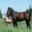

In [22]:
image = PIL.Image.open(image_name); image

# Define CIFAR10 Dataset

In [6]:
class CIFARDataset(Dataset):
    def __init__(self, labels, data_dir, transform=None):
        self.labels = labels
        self.data_dir = data_dir
        self.transform = transform
        classes = sorted(list(set(labels['label'].tolist())));
        self.class2idx = {k:i for i, k in enumerate(classes)}
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image_path = f'{self.data_dir}/{self.labels.iloc[idx, 0]}{suffix}'
        image = PIL.Image.open(image_path)
        labels = self.class2idx[self.labels.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        return [image, labels]
           

In [7]:
class CIFARTestDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.data_files_list = [f for f in os.listdir(f'{self.data_dir}') if os.path.isfile(os.path.join(f'{self.data_dir}', f))]
        
    def __len__(self):
        return len(self.data_files_list)
    
    def __getitem__(self, idx):
        image_path = os.path.join(f'{self.data_dir}', self.data_files_list[idx])
        image = PIL.Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image
    
    @property
    def filenames(self):
        return self.data_files_list
        

# Find dataset mean/std

In [6]:
train_ds = CIFARDataset(labels, f'{PATH}train', transform=transforms.ToTensor())
train_dl = DataLoader(train_ds, batch_size=100, shuffle=True, num_workers=4)

In [7]:
def getMeanStd(dataset, sz, bs):
    dl = DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=4)
    itr = iter(dl)
    sum = 0
    for X,Y in itr:
        sum = sum + np.sum(X.numpy(), axis=(0,2,3))
    mean = sum / (sz*sz*len(dataset))
    std_sum = 0;
    for X,Y in iter(dl):
        xt = np.transpose(X.numpy(), axes=(0,2,3,1));
        std_sum = std_sum + np.sum((xt-mean)**2, axis=(0,1,2))
    std = np.sqrt(std_sum / (sz*sz*len(dataset)))
    return mean, std

In [8]:
mean, std = getMeanStd(train_ds, 32, 100); mean, std

(array([0.49139977, 0.4821584 , 0.4465309 ]),
 array([0.24703224, 0.24348513, 0.26158784]))

# Create Dataloader

In [8]:
def getTransforms(sz,  mean, std, aug=False):
    normalize = transforms.Normalize(
       mean=mean,
       std=std
    )
    if aug==True:
        ds_trans = transforms.Compose([transforms.Resize(sz),
                                       transforms.RandomCrop(sz, sz//8),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       normalize])
    else:
        ds_trans = transforms.Compose([transforms.Resize(sz),
                                       transforms.ToTensor(),
                                       normalize])
    return ds_trans

def getDataLoader(dataset, bs):
    return DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=4)

In [9]:
sz = 32
bs = 128

data_labels = pd.read_csv(f'{PATH}trainLabels.csv')
train_labels = data_labels.sample(frac=0.8,random_state=200)
valid_labels = data_labels.drop(train_labels.index)

train_ds = CIFARDataset(train_labels, f'{PATH}train', transform=getTransforms(sz, mean, std, aug=True))
valid_ds = CIFARDataset(valid_labels, f'{PATH}train', transform=getTransforms(sz, mean, std))
test_ds = CIFARTestDataset(f'{PATH}test', transform=getTransforms(sz, mean, std))

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=4)

len(train_labels), len(valid_labels)

(40000, 10000)

# Examine the images

In [27]:
img, Y = next(iter(train_dl))

In [28]:
print(img.size(), Y.size())

torch.Size([128, 3, 32, 32]) torch.Size([128])


In [29]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([128, 3, 32, 32]) torch.Size([128])


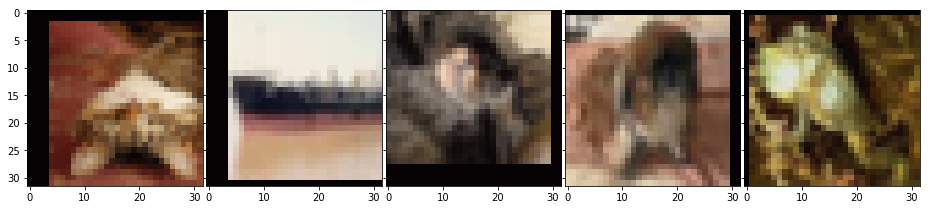

In [37]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 5), axes_pad=0.05)    
for i in range(5):
    ax = grid[i]
    imshow(ax, img[i])
    #ax.imshow(img[i].numpy().transpose((1, 2, 0)))
    

# SGDR - First version(Pack everything into a single function)

The purpose of this section is to get a general idea of how all the pytorch components fit together to make things happen. I kept everything including the loops, learning rate changes, calculations in a single function. Hopefully, by showing these step in plain sight without the need of tracing the procedures through layers of abstraction, it will looks less intimidating as than it should look.

In [10]:
def get_learning_rate(optimizer):
    lr=[]
    for param_group in optimizer.param_groups:
       lr +=[ param_group['lr'] ]
    return lr

We are going to use the "lambdaLR" class from "torch.optim" to implement cosine annealing of the learning rate as well as the restarts. The period(cycle_len) is calculated by finding the inverse of the geometric progression sum given the number of batch iterations that have ran. The lambda scheduler.step() should be called in the most inner loop that iterates through the batch iterations.

P.S. Since the scheduler class has no reset functionality, the initial goal was to avoid re-creating a scheduler every cycle by making a scheduler that could be placed in a loop and works. I later realized this has make it way more complicated than it should look. Maybe I'll write a new scheduler class on next version

In [11]:
def numpy_log(x, base):
    return np.log(x)/np.log(base)

def getCosineAnnealingLambda(cycle_len, cycle_mult=1):
    if cycle_mult == 1:
        return lambda i: 1 / 2 * (1 + np.cos(np.pi*(i % cycle_len) / cycle_len))
    
    power = lambda i: np.floor(numpy_log((i)/cycle_len*(cycle_mult-1)+1, cycle_mult))
    period = lambda i: cycle_len * (cycle_mult ** power(i))
    psum = lambda i: cycle_len*(cycle_mult**(power(i))-1)/(cycle_mult-1)
    current = lambda i:  (1 + (i-psum(i)-1)) % period(i)
    getLr = lambda i: 1 / 2 * (1 + np.cos(np.pi*current(i) / period(i)))
    return getLr


In [12]:
def train_cos_anneal_model(dataloaders, model, criterion, optimizer, bs, num_cycle, cycle_len=1, cycle_mult=1):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    
    dataset_sizes = { 'train': len(dataloaders['train'].dataset),
                      'valid': len(dataloaders['valid'].dataset)}
    
    recorder = { 'train_loss': [],
                 'valid_loss': [],
                 'train_epoch_loss': [],
                 'valid_epoch_loss': [],
                 'train_epoch_acc': [],
                 'valid_epoch_acc': [],
                 'lr': []}
    
    epoch = 0
    
    iter_per_train_epoch = np.ceil(dataset_sizes['train'] / dataloaders['train'].batch_size)
    
    cos_lambda_scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=getCosineAnnealingLambda(iter_per_train_epoch*cycle_len, cycle_mult))
    cos_lambda_scheduler.step()
    lrs = []
    
    for cycle in range(num_cycle):
        for cycle_epoch in range(cycle_len*cycle_mult**cycle):
            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train(True)
                else:
                    model.train(False)

                running_loss = 0.0
                running_corrects = 0
                running_data_size = 0
                running_train_loss = 0.0
                running_valid_loss = 0.0
                running_train_acc = 0.0
                running_valid_acc = 0.0
                    
                pbar = tqdm(dataloaders[phase], leave=True, desc='Epoch:[{}]|{}|'.format(epoch, phase))
                for inputs, labels in pbar:
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                        
                    optimizer.zero_grad()
                    
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        recorder['lr'].append(cos_lambda_scheduler.get_lr( ))
                        
                        loss.backward()
                        optimizer.step()
                        cos_lambda_scheduler.step()
                        
                    running_loss += loss.data[0]
                    running_corrects += torch.sum(preds == labels.data)
                    
                    running_data_size += inputs.data.size(0)
                    if phase == 'train':
                        running_train_loss = running_loss / running_data_size
                        running_train_acc = running_corrects / running_data_size
                        recorder['train_loss'].append(running_train_loss)
                        pbar.set_postfix_str('Train Loss: {:.4f}, Train Acc: {:.4f}'
                                             .format(running_train_loss, running_train_acc))
                    else:
                        running_valid_loss = running_loss / running_data_size
                        running_valid_acc = running_corrects / running_data_size
                        recorder['valid_loss'].append(running_valid_loss)
                        pbar.set_postfix_str('Valid Loss: {:.4f}, Valid Acc: {:.4f}'
                                             .format(running_valid_loss, running_valid_acc))

                    
                if phase == 'train':
                    recorder['train_epoch_loss'].append(running_loss / dataset_sizes[phase])
                    recorder['train_epoch_acc'].append(running_corrects / dataset_sizes[phase])
                else:
                    recorder['valid_epoch_loss'].append(running_loss / dataset_sizes[phase])
                    recorder['valid_epoch_acc'].append(running_corrects / dataset_sizes[phase])
       
            
            epoch += 1
    print('{:5s}  {:5s}  {:10s}  {:9s}  {:10s}  {:9s}'
          .format('Cycle', 'Epoch', 'Train_Loss', 'Train_Acc', 'Valid_Loss', 'Valid_Acc'))
    for e in range(epoch):
        print('{:5d}  {:5d}  {:10.7f}  {:9.7f}  {:10.7f}  {:9.7f}'.format(
                    cycle, e,
                    recorder['train_epoch_loss'][e], recorder['train_epoch_acc'][e], 
                    recorder['valid_epoch_loss'][e], recorder['valid_epoch_acc'][e]))        
    return model, recorder;
    #return lrs

In [13]:
arch = SENet18().cuda()

In [14]:
#load pre-trained weights, skip if it doesnt exist
p =  f'{PATH}weights/cifar10_snet_1.pt'
pretrained_weights = torch.load(p, map_location=lambda storage, loc: storage)
arch.load_state_dict(pretrained_weights)

In [15]:
lr = 1e-2
wd = 5e-4

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(arch.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
dloaders = {'train':train_dl, 'valid':valid_dl}

In [16]:
arch, recorder = train_cos_anneal_model(dloaders, arch, criterion, optimizer, 128, 2, cycle_len=1, cycle_mult=2 )

Epoch:[0]|train|: 100%|██████████| 313/313 [02:42<00:00,  1.93it/s, Train Loss: 0.0001, Train Acc: 0.9947]
Epoch:[0]|valid|: 100%|██████████| 79/79 [00:35<00:00,  2.26it/s, Valid Loss: 0.0022, Valid Acc: 0.9310]
Epoch:[1]|train|: 100%|██████████| 313/313 [00:27<00:00, 11.20it/s, Train Loss: 0.0004, Train Acc: 0.9847]
Epoch:[1]|valid|: 100%|██████████| 79/79 [00:02<00:00, 33.71it/s, Valid Loss: 0.0025, Valid Acc: 0.9170]
Epoch:[2]|train|: 100%|██████████| 313/313 [00:28<00:00, 11.11it/s, Train Loss: 0.0001, Train Acc: 0.9968]
Epoch:[2]|valid|: 100%|██████████| 79/79 [00:02<00:00, 34.24it/s, Valid Loss: 0.0022, Valid Acc: 0.9298]

Cycle  Epoch  Train_Loss  Train_Acc  Valid_Loss  Valid_Acc
    1      0   0.0001290  0.9947250   0.0021675  0.9310000
    1      1   0.0003525  0.9847000   0.0025255  0.9170000
    1      2   0.0000963  0.9968000   0.0021596  0.9298000


In [17]:
os.listdir(f'{PATH}weights')
torch.save(arch.state_dict(), f'{PATH}weights/cifar10_snet_1.pt')

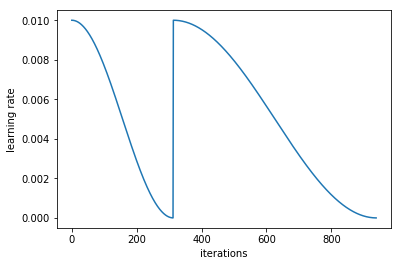

In [18]:
fig = plt.figure()
plt.xlabel("iterations")
plt.ylabel("learning rate")
plt.plot(np.arange(0, len(recorder['lr']),1), recorder['lr'])

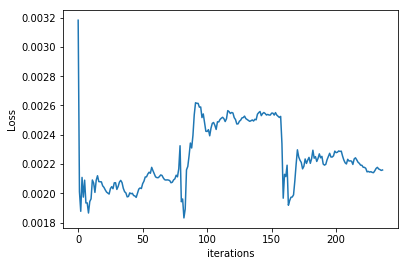

In [19]:
fig = plt.figure()
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.plot(np.arange(0, len(recorder['valid_loss']),1), recorder['valid_loss'])

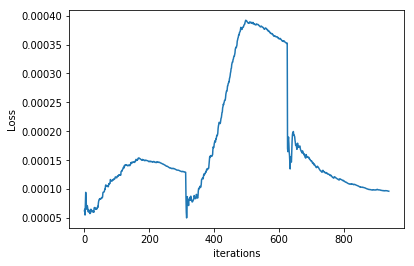

In [20]:
fig = plt.figure()
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.plot(np.arange(0, len(recorder['train_loss']),1), recorder['train_loss'])

# Abstract SGDR into a class

In [10]:
def numpy_log(x, base):
    return np.log(x)/np.log(base)

class Data:
    def __init__(self, train_dl, valid_dl, test_dl=None, bs=1):
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.test_dl = test_dl;
        self.bs = bs

def get_data(df, train_dir, sz, bs, test_dir=None, frac=0.8, rnd_seed=200):
    train_labels = data_labels.sample(frac=frac,random_state=rnd_seed)
    valid_labels = data_labels.drop(train_labels.index)

    train_ds = CIFARDataset(train_labels, f'{PATH}train', transform=getTransforms(sz, mean, std, aug=True))
    valid_ds = CIFARDataset(valid_labels, f'{PATH}train', transform=getTransforms(sz, mean, std))
    test_ds = CIFARTestDataset(f'{PATH}test', transform=getTransforms(sz, mean, std))

    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
    valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=4)
    
    if test_dir:
        test_ds = CIFARTestDataset(test_dir, transform=getTransforms(sz, mean, std))
        test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=4)
    
    return Data(train_dl, valid_dl, test_dl, bs)

In [12]:
class Recorder:
    
    def __init__(self):
        self.acc_loss = 0.0
        self.acc_corrects = 0.0
        self.acc_datasize = 0.0
        self.current_loss = []
        self.current_corrects = []
        self.lr = []
        self.model_snapshots = []
        
        self.batch_count = 0
        
    def on_batch_end(self, batch_loss, batch_corrects, batch_datasize, lr):
        self.acc_loss += batch_loss
        self.acc_corrects += batch_corrects
        self.acc_datasize += batch_datasize
        
        self.current_loss.append(self.acc_loss / self.acc_datasize)
        self.current_corrects.append(self.acc_corrects / self.acc_datasize)
        self.lr.append(lr)
        
        self.batch_count += 1
        
    def on_epoch_end(self):
        self.acc_loss = 0.0
        self.acc_corrects = 0.0
        self.acc_datasize = 0.0
        
    def on_cycle_end(self, model):
        iteration = self.batch_count - 1
        self.model_snapshots.append({'iteration': iteration,
                                     'loss': self.current_loss[iteration],
                                     'accuracy': self.current_corrects[iteration],
                                     'state_dict': model.state_dict()                                    
                                    })


class Learner:
    
    def __init__(self, model, data=None):
        self.model = model
        self.data = data
        
    def set_data(self, data):
        self.data = data;
        
    def save_model(self, fullPath):
        torch.save(self.model.state_dict(), fullPath)
        
    def load_model(self, fullPath):
        weights = torch.load(fullPath, map_location=lambda storage, loc: storage)
        self.model.load_state_dict(weights)
        
    def fit(self, lr, num_cycle, wd=0, momentum=0, cycle_len=None, cycle_mult=1):
        criterion = torch.nn.NLLLoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr, weight_decay=wd, momentum=momentum)
        scheduler = None
        if cycle_len != None:
            scheduler = self.__createSGDRScheduler(optimizer, len(self.data.train_dl.dataset), cycle_len, cycle_mult)
            
        self.model, recorder = self.__train(optimizer, criterion, scheduler, num_cycle, cycle_len, cycle_mult)
        return self.model, recorder
    
    def __train(self, optimizer, criterion, scheduler,  num_cycle, cycle_len=None, cycle_mult=1):
        since = time.time()
        use_gpu = torch.cuda.is_available()
        
        dataloaders = { 'train': self.data.train_dl,
                        'valid': self.data.valid_dl }
        
        recorder = { 'train': Recorder(),
                     'valid': Recorder() }
    
        lr = optimizer.param_groups[0]['lr']
        epoch = 0
        num_cycle_epoch = 1
        
        if (scheduler):
            scheduler.step()
        self.print_stats_header()
        
        for cycle in range(num_cycle):
            if cycle_len != None:
                num_cycle_epoch = cycle_len*cycle_mult**cycle
                
            for cycle_epoch in range(num_cycle_epoch):
                for phase in ['train', 'valid']:
                    if phase == 'train':
                        self.model.train(True)
                    else:
                        self.model.train(False)

                    pbar = self.create_batch_progressbar(dataloaders[phase], epoch, phase)
                    for inputs, labels in pbar:
                        if use_gpu:
                            inputs, labels = inputs.cuda(), labels.cuda()
                        inputs, labels = Variable(inputs), Variable(labels)

                        optimizer.zero_grad()

                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs.data, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            if (scheduler):
                                lr = scheduler.get_lr()
                                scheduler.step()

                        batch_loss = loss.item()
                        batch_corrects = torch.sum(preds == labels.data).item()
                        batch_data_size = inputs.data.size(0)
                        
                        recorder[phase].on_batch_end(batch_loss,
                                                     batch_corrects,
                                                     batch_data_size,
                                                     lr)
                        self.update_batch_progressbar(pbar, recorder[phase], phase)
                        
                    recorder[phase].on_epoch_end()
                
                self.print_stats(cycle, epoch, recorder)
                epoch += 1
                
            recorder['valid'].on_cycle_end(self.model)
                
        return self.model, recorder;
    
    def predict(self, test_dl=None):
        if test_dl is None and self.data.test_dl is None:
            print('No test dataset')
            return
        
        if test_dl is None:
            test_dl = self.data.test_dl
            
        since = time.time()
        use_gpu = torch.cuda.is_available()
        self.model.train(False)
        result = None
        
        for inputs in tqdm(test_dl):
            if use_gpu:
                inputs = inputs.cuda()
            inputs = Variable(inputs, volatile=True, requires_grad=False)

            outputs = self.model(inputs)
            if result is None:
                result = outputs
            else:
                result = torch.cat((result, outputs))
                
        if use_gpu:
            result = result.data.cpu()
        return result.numpy()
        
    def __createSGDRScheduler(self, optimizer, dataset_len, cycle_len, cycle_mult=1):
        iter_per_epoch =  np.ceil(dataset_len / self.data.bs)
        SGDRlambda = self.__getCosineAnnealingLambda(iter_per_epoch*cycle_len, cycle_mult)
        cos_lambda_scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=SGDRlambda)
        return cos_lambda_scheduler
    
    def __getCosineAnnealingLambda(self, cycle_len, cycle_mult=1):
        if cycle_mult == 1:
            return lambda i: 1 / 2 * (1 + np.cos(np.pi*(i % cycle_len) / cycle_len))

        power = lambda i: np.floor(numpy_log((i)/cycle_len*(cycle_mult-1)+1, cycle_mult))
        period = lambda i: cycle_len * (cycle_mult ** power(i))
        psum = lambda i: cycle_len*(cycle_mult**(power(i))-1)/(cycle_mult-1)
        current = lambda i:  (1 + (i-psum(i)-1)) % period(i)
        getLr = lambda i: 1 / 2 * (1 + np.cos(np.pi*current(i) / period(i)))
        return getLr
    
    def create_batch_progressbar(self, dataloader, epoch, phase):
        return tqdm(dataloader, file=sys.stdout, leave=False, desc='Epoch:[{}]|{}|'.format(epoch, phase))
    
    def update_batch_progressbar(self, progess_bar, recorder, phase):
        progess_bar.set_postfix_str('|{}| Loss: {:.4f}, Acc: {:.4f}'
                             .format(phase, recorder.current_loss[-1], recorder.current_corrects[-1]))
        
    def print_stats(self, cycle, epoch, recorder):
        print('{:5d}  {:5d}  {:10.7f}  {:9.7f}  {:10.7f}  {:9.7f}'
              .format(cycle, epoch,
               recorder['train'].current_loss[-1], recorder['train'].current_corrects[-1], 
               recorder['valid'].current_loss[-1], recorder['valid'].current_corrects[-1]))
        
    def print_stats_header(self):
        print('{:5s}  {:5s}  {:10s}  {:9s}  {:10s}  {:9s}'
              .format('Cycle', 'Epoch', 'Train_Loss', 'Train_Acc', 'Valid_Loss', 'Valid_Acc'))
        

In [13]:
arch = SENet18().cuda()


In [14]:
learn = Learner(arch)

In [15]:
learn.load_model(f'{PATH}weights/learner_snet_1.pt')

In [16]:
data_labels = pd.read_csv(f'{PATH}trainLabels.csv')
learn.set_data(get_data(data_labels, f'{PATH}train', 32, 128, test_dir=f'{PATH}test'))

lr = 1e-3
wd = 5e-4
#model, recorder = learn.fit(lr, 3, cycle_len=1, cycle_mult=2, momentum=0.9, wd=wd)
model, recorder = learn.fit(lr, 4, cycle_len=1, cycle_mult=2, momentum=0.9, wd=wd)

Cycle  Epoch  Train_Loss  Train_Acc  Valid_Loss  Valid_Acc
    0      0   0.0000109  1.0000000   0.0021544  0.9322000                                            
    1      1   0.0000125  0.9999500   0.0021340  0.9333000                                            
    1      2   0.0000122  0.9999000   0.0021324  0.9321000                                            
    2      3   0.0000122  0.9999000   0.0021249  0.9319000                                            
    2      4   0.0000100  0.9999750   0.0022025  0.9320000                                            
    2      5   0.0000098  0.9999500   0.0021409  0.9324000                                            
    2      6   0.0000102  0.9999750   0.0021586  0.9315000                                            
    3      7   0.0000104  0.9999750   0.0021535  0.9330000                                            
    3      8   0.0000111  0.9999500   0.0022168  0.9318000                                            
    3      9  

In [17]:
[m['accuracy'] for m in recorder['valid'].model_snapshots]
#model.training

[0.9322, 0.9321, 0.9315, 0.9333]

In [18]:
learn.save_model(f'{PATH}weights/learner_snet_1.pt')

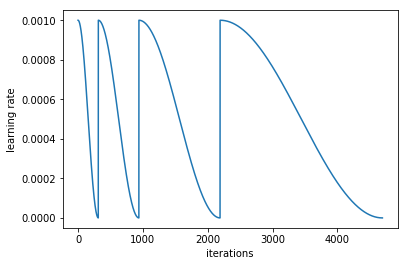

In [19]:
fig = plt.figure()
plt.xlabel("iterations")
plt.ylabel("learning rate")
plt.plot(np.arange(0, len(recorder['train'].lr),1), recorder['train'].lr)

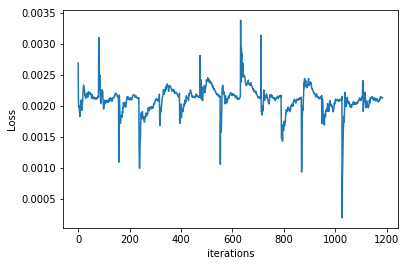

In [20]:
fig = plt.figure()
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.plot(np.arange(0, len(recorder['valid'].current_loss),1), recorder['valid'].current_loss)

# Snapshot Ensemble

In [48]:
log_pred_list = []

model_list = [m['state_dict'] for m in recorder['valid'].model_snapshots]
for m in model_list:
    learn.model.load_state_dict(m)
    log_pred = learn.predict()
    log_pred_list.append(log_pred)    

100%|██████████| 2344/2344 [00:54<00:00, 42.63it/s]


In [49]:
log_pred = np.mean(log_pred_list, 0)

In [50]:
probs = np.exp(log_pred)
pred = np.argmax(probs, 1)
result = np.array(classes)[pred]

In [51]:
df = pd.DataFrame(result, columns=['label'])
df.insert(0, 'id', [f[:-4] for f in test_ds.filenames])

In [52]:
df.head()

,id,label
0,152776,cat
1,2537,frog
2,15821,dog
3,281503,truck
4,204930,cat


In [53]:
SUBM = f'{PATH}sub/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.csv', compression=None, index=False)

In [54]:
from IPython.lib.display import FileLink
FileLink(f'{SUBM}subm.csv')

/data/cifar10_kaggle/sub/subm.csv

# Train with increasing data size

In [15]:
bs=128
data_sizes = [4, 8, 16, 32]
lrs = [1e-2, 1e-2, 1e-3, 1e-3]
wd = 5e-4
momentum = 0.9

data_labels = pd.read_csv(f'{PATH}trainLabels.csv')

arch = SENet18().cuda()
learn = Learner(arch)

for sz,lr in zip(data_sizes, lrs):
    print(f'Train with size={sz}:')
    learn.set_data(get_data(data_labels, f'{PATH}train', sz, bs, test_dir=f'{PATH}test'))
    learn.fit(lr, 4, cycle_len=1, cycle_mult=2, momentum=momentum, wd=wd)
    print(f'============================================================')


Train with size=4:
Cycle  Epoch  Train_Loss  Train_Acc  Valid_Loss  Valid_Acc
    0      0   0.0132488  0.3915500   0.0121044  0.4492000                                            
    1      1   0.0120223  0.4496750   0.0114735  0.4766000                                            
    1      2   0.0107280  0.5170000   0.0109097  0.5030000                                            
    2      3   0.0111773  0.4910250   0.0112382  0.4867000                                            
    2      4   0.0104701  0.5236750   0.0108159  0.5069000                                            
    2      5   0.0096884  0.5616500   0.0103509  0.5332000                                            
    2      6   0.0090388  0.5929250   0.0102487  0.5364000                                            
    3      7   0.0103346  0.5298000   0.0109029  0.5054000                                            
    3      8   0.0099173  0.5515000   0.0106346  0.5236000                                        

In [17]:
learn.set_data(get_data(data_labels, f'{PATH}train', 32, 128, test_dir=f'{PATH}test'))
learn.fit(1e-3, 4, cycle_len=2, cycle_mult=2, momentum=0.9, wd=5e-4)

Cycle  Epoch  Train_Loss  Train_Acc  Valid_Loss  Valid_Acc
    0      0   0.0018149  0.9175000   0.0032819  0.8644000                                            
    0      1   0.0014175  0.9381750   0.0027748  0.8828000                                            
    1      2   0.0017943  0.9205500   0.0032664  0.8666000                                            
    1      3   0.0016013  0.9283250   0.0030878  0.8727000                                            
    1      4   0.0013458  0.9425000   0.0027689  0.8868000                                            
    1      5   0.0011844  0.9497250   0.0027293  0.8874000                                            
    2      6   0.0016768  0.9246750   0.0034665  0.8622000                                            
    2      7   0.0015848  0.9283250   0.0032825  0.8678000                                            
    2      8   0.0014710  0.9334500   0.0036519  0.8563000                                            
    2      9  

(SENet(
   (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   (layer1): Sequential(
     (0): PreActBlock(
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
       (fc2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
     )
     (1): PreActBlock(
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

It seems by using this method, the model is less likely to overfit than keep the same size throughtout the training process. The training loss and valid loss are more likely to improve in the same pace. However, if we try to push our valid accuracy by overfitting our model, we would still get similar result as the traditional method. 

# Another experiment (Stop before overfitting)

In [35]:
learn.set_data(get_data(data_labels, f'{PATH}train', 32, 128, test_dir=f'{PATH}test'))
model, recorder = learn.fit(1e-2, 3, cycle_len=3, cycle_mult=1, momentum=0.9, wd=5e-4)

Cycle  Epoch  Train_Loss  Train_Acc  Valid_Loss  Valid_Acc
    0      0   0.0010415  0.9534000   0.0027510  0.8922000                                            
    0      1   0.0006099  0.9736750   0.0021180  0.9138000                                            
    0      2   0.0003091  0.9882500   0.0019953  0.9217000                                            
    1      3   0.0009698  0.9563750   0.0032026  0.8790000                                            
    1      4   0.0005687  0.9751500   0.0021127  0.9173000                                            
    1      5   0.0002866  0.9887500   0.0020613  0.9231000                                            
    2      6   0.0009438  0.9566750   0.0028237  0.8942000                                            
    2      7   0.0005389  0.9769750   0.0021376  0.9179000                                            
    2      8   0.0002600  0.9910750   0.0020852  0.9228000                                            


In [43]:
[m['accuracy'] for m in recorder['valid'].model_snapshots]
#model.training

[0.9217, 0.9231, 0.9228]

I did a snapshot ensemble and submitted the results to kaggle. The results were not better. (92.7%) So it seems this is not a better generalized minimum.